对$n$维样本空间$\mathcal X$中的随机向量$\mathbf x$，若$\mathbf x$服从高斯分布，其概率密度函数为$p(\mathbf x) = \frac1{(2\pi)^\frac n2|\Sigma|^\frac12}e^{-\frac12(\mathbf x - \mathbf\mu)^\top\Sigma^{-1}(\mathbf x - \mathbf\mu)}$，其中$\mathbf\mu$是$n$维均值向量，$\Sigma$是$n \times n$的协方差矩阵。为了明确显示高斯分布与相应参数的依赖关系，将概率密度函数记为$p(\mathbf x| \mathbf\mu_i, \Sigma_i)$

我们可定义高斯混合分布$p_\mathcal M(\mathbf x) = \sum_{i = 1}^k\alpha_ip(\mathbf x | \mathbf\mu_i, \Sigma_i)$，该分布共由$k$个混合成分组成，每个混合成分对应一个高斯分布。其中$\mathbf\mu_i$与$\Sigma_i$是第$i$个高斯混合成分的参数，而$\alpha_i > 0$为相应的”混合系数“，$\sum_{i = 1}^k\alpha_i = 1$

假设样本的生成过程由高斯混合分布给出：首先，根据$\alpha_1, \alpha_2, \dots, \alpha_k$定义的先验分布选择高斯混合成分，其中$\alpha_i$为选择第$i$个混合成分的概率；然后，根据被选择的混合成分的概率密度函数进行采样，从而生成相应的样本

若训练集$D = \{\mathbf x_1, \mathbf x_2, \dots, \mathbf x_m\}$由上述过程生成，令随机变量$z_j \in \{1, 2, \dots, k\}$表示生成样本$\mathbf x_j$的高斯混合成分，其取值未知。显然，$z_j$的先验概率$P(z_j = i)$对应于$\alpha_i(i = 1, 2, \dots, k)$。根据贝叶斯定理，$z_j$的后验分布对应于$p_\mathcal M(z_j = i | \mathbf x_j) = \frac{P(z_j = i)p_\mathcal M(\mathbf x_j | z_j = i)}{p_\mathcal M(\mathbf x_j)} = \frac{\alpha_ip(\mathbf x_j | \mathbf\mu_i, \Sigma_i)}{\sum_{l = 1}^k\alpha_ip(\mathbf x_j | \mathbf\mu_l, \Sigma_l)}$

换言之，$p_\mathcal M(z_j = i | \mathbf x_j)$给出了样本$x_j$由第$i$个高斯混合成分生成的后验概率。为方便叙述，将其简记为$\gamma_{ji}(i = 1, 2, \dots, k)$

$$\lambda_j = \argmax_{i \in \{1, 2, \dots, k\}}\gamma_{ji}$$

显然，给定样本集$D$，可采用极大似然估计，即最大化（对数）似然$LL(D) = \ln(\prod_{j = 1}^mp_\mathcal M(\mathbf x_j)) = \sum_{j = 1}^m\ln(\sum_{i = 1}^k\alpha_ip(\mathbf x_j | \mathbf\mu_i, \Sigma_i))$，常采用EM算法进行迭代优化求解
$$\frac{\partial LL(D)}{\partial\mathbf\mu_i} = 0 \Rightarrow \sum_{j = 1}^m\frac{\alpha_ip(\mathbf x_j | \mathbf\mu_i, \Sigma_i)}{\sum_{l = 1}^k\alpha_lp(\mathbf x_j | \mathbf\mu_l, \Sigma_l)}(\mathbf x_j - \mathbf\mu_i) = 0 \Rightarrow \mathbf\mu_i = \frac{\sum_{j = 1}^m\gamma_{ji}\mathbf x_j}{\sum_{j = 1}^m\gamma_{ji}}$$
$$\frac{\partial LL(D)}{\partial\Sigma_i} = 0 \Rightarrow \Sigma_i = \frac{\sum_{j = 1}^m\gamma_{ji}(\mathbf x_j - \mathbf\mu_i)(\mathbf x_j - \mathbf\mu_i)^\top}{\sum_{j = 1}^m\gamma_{ji}}$$
对于混合系数$\alpha_i$，除了要最大化$LL(D)$，还需满足$\alpha_i \ge 0, \sum_{i = 1}^k\alpha_i = 1$。考虑$LL(D)$的拉格朗日形式$LL(D) + \lambda(\sum_{i = 1}^k\alpha_i - 1) \Rightarrow \sum_{j = 1}^m\frac{p(\mathbf x_j | \mathbf\mu_i, \Sigma_i)}{\sum_{l = 1}^k\alpha_lp(\mathbf x_j | \mathbf\mu_l, \Sigma_l)} + \lambda = 0 \Rightarrow \alpha_i = \frac1m\sum_{j = 1}^m\gamma_{ji}$，即每个高斯成分的混合系数由样本属于该成分的平均后验概率确定
![高斯混合聚类算法](Mixture-of-Gaussian.png "高斯混合聚类算法")

In [25]:
import numpy as np

from pathlib import Path
from sklearn.datasets import make_blobs, make_moons
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from scipy.stats import norm


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
    

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)


X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [26]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [27]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [28]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

In [29]:
gm.converged_

True

In [30]:
gm.n_iter_

4

In [31]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1], dtype=int64)

In [32]:
gm.predict_proba(X).round(3)

array([[0.   , 0.023, 0.977],
       [0.001, 0.016, 0.983],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]])

In [33]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [34]:
y_new

array([0, 0, 1, 1, 1, 2])

In [35]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81])

In [36]:
# extra code – bonus material

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999225089

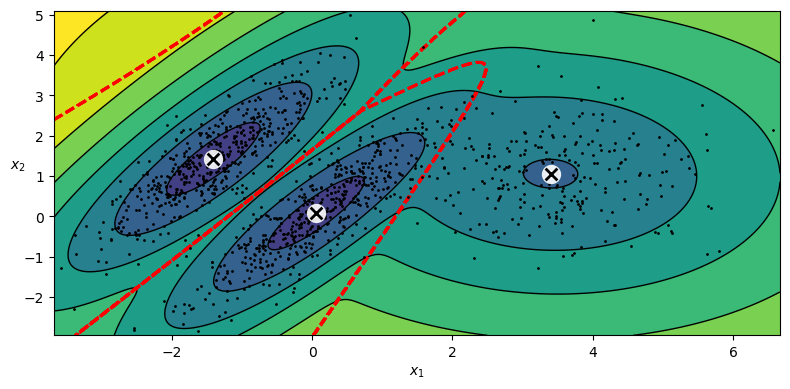

In [37]:
# extra code – this cells generates and saves Figure 9–16

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)


plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known

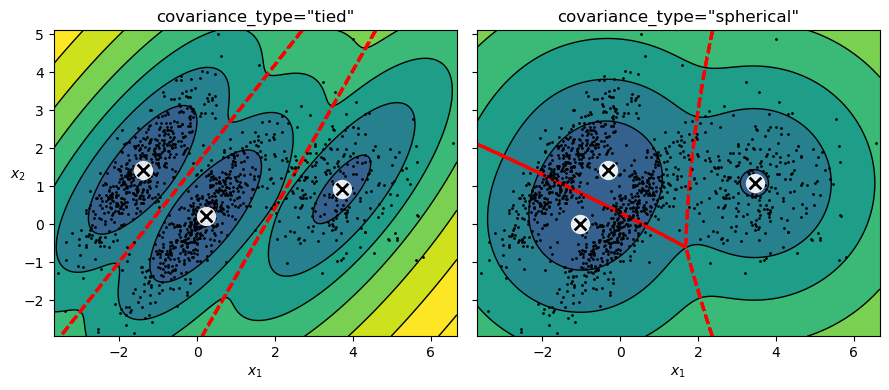

In [38]:
# extra code – this cell generates and saves Figure 9–17

gm_full = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10,
                               covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)


def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"')


compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

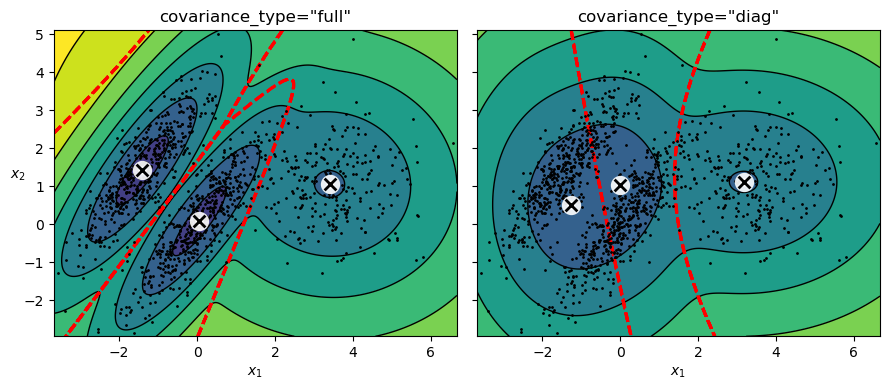

In [39]:
# extra code – comparing covariance_type="full" and covariance_type="diag"
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### Anomaly Detection Using Gaussian Mixtures

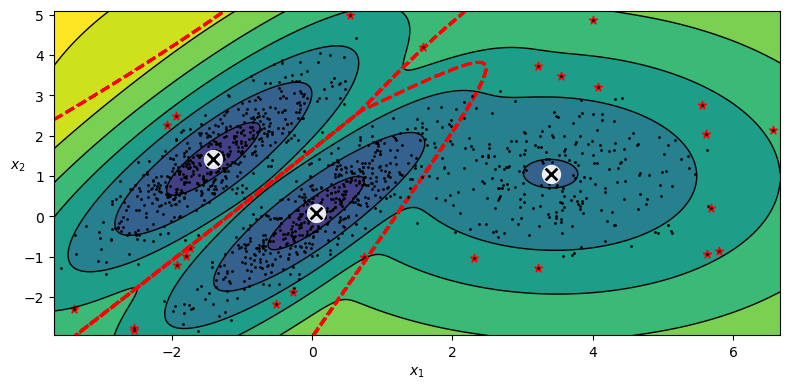

In [40]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

# extra code – this cell generates and saves Figure 9–18

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

### Selecting the Number of Clusters

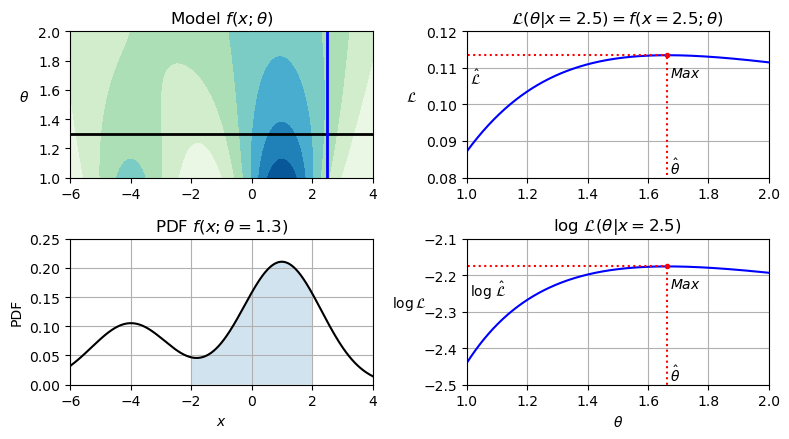

In [41]:
# extra code – this cell generates and saves Figure 9–19

x_val = 2.5
std_val = 1.3
x_range = [-6, 4]
x_proba_range = [-2, 2]
stds_range = [1, 2]

xs = np.linspace(x_range[0], x_range[1], 501)
stds = np.linspace(stds_range[0], stds_range[1], 501)
Xs, Stds = np.meshgrid(xs, stds)
Z = 2 * norm.pdf(Xs - 1.0, 0, Stds) + norm.pdf(Xs + 4.0, 0, Stds)
Z = Z / Z.sum(axis=1)[:, np.newaxis] / (xs[1] - xs[0])

x_example_idx = (xs >= x_val).argmax()  # index of the first value >= x_val
max_idx = Z[:, x_example_idx].argmax()
max_val = Z[:, x_example_idx].max()
s_example_idx = (stds >= std_val).argmax()
x_range_min_idx = (xs >= x_proba_range[0]).argmax()
x_range_max_idx = (xs >= x_proba_range[1]).argmax()
log_max_idx = np.log(Z[:, x_example_idx]).argmax()
log_max_val = np.log(Z[:, x_example_idx]).max()

plt.figure(figsize=(8, 4.5))

plt.subplot(2, 2, 1)
plt.contourf(Xs, Stds, Z, cmap="GnBu")
plt.plot([-6, 4], [std_val, std_val], "k-", linewidth=2)
plt.plot([x_val, x_val], [1, 2], "b-", linewidth=2)
plt.ylabel(r"$\theta$", rotation=0, labelpad=10)
plt.title(r"Model $f(x; \theta)$")

plt.subplot(2, 2, 2)
plt.plot(stds, Z[:, x_example_idx], "b-")
plt.plot(stds[max_idx], max_val, "r.")
plt.plot([stds[max_idx], stds[max_idx]], [0, max_val], "r:")
plt.plot([0, stds[max_idx]], [max_val, max_val], "r:")
plt.text(stds[max_idx]+ 0.01, 0.081, r"$\hat{\theta}$")
plt.text(stds[max_idx]+ 0.01, max_val - 0.006, r"$Max$")
plt.text(1.01, max_val - 0.008, r"$\hat{\mathcal{L}}$")
plt.ylabel(r"$\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\mathcal{{L}}(\theta|x={x_val}) = f(x={x_val}; \theta)$")
plt.grid()
plt.axis([1, 2, 0.08, 0.12])

plt.subplot(2, 2, 3)
plt.plot(xs, Z[s_example_idx], "k-")
plt.fill_between(xs[x_range_min_idx:x_range_max_idx+1],
                 Z[s_example_idx, x_range_min_idx:x_range_max_idx+1], alpha=0.2)
plt.xlabel(r"$x$")
plt.ylabel("PDF")
plt.title(fr"PDF $f(x; \theta={std_val})$")
plt.grid()
plt.axis([-6, 4, 0, 0.25])

plt.subplot(2, 2, 4)
plt.plot(stds, np.log(Z[:, x_example_idx]), "b-")
plt.plot(stds[log_max_idx], log_max_val, "r.")
plt.plot([stds[log_max_idx], stds[log_max_idx]], [-5, log_max_val], "r:")
plt.plot([0, stds[log_max_idx]], [log_max_val, log_max_val], "r:")
plt.text(stds[log_max_idx]+ 0.01, log_max_val - 0.06, r"$Max$")
plt.text(stds[log_max_idx]+ 0.01, -2.49, r"$\hat{\theta}$")
plt.text(1.01, log_max_val - 0.08, r"$\log \, \hat{\mathcal{L}}$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\log\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\log \, \mathcal{{L}}(\theta|x={x_val})$")
plt.grid()
plt.axis([1, 2, -2.5, -2.1])

save_fig("likelihood_function_plot")
plt.show()

In [42]:
gm.bic(X)

8189.733705221638

In [43]:
gm.aic(X)

8102.5084251066

In [44]:
# extra code – bonus material
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood
print(f"bic = {bic}")
print(f"aic = {aic}")
print(f"n_params = {n_params}")

bic = 8189.733705221638
aic = 8102.5084251066
n_params = 17


c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known

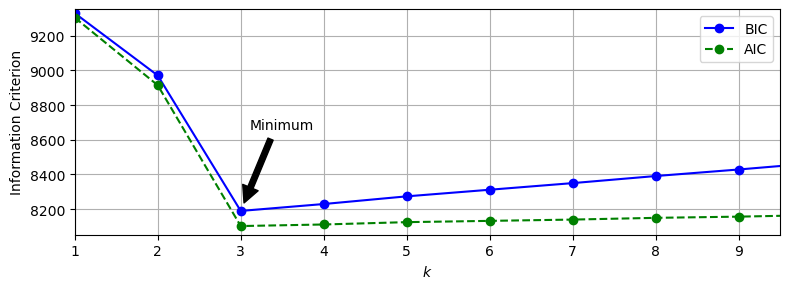

In [45]:
# extra code – this cell generates and saves Figure 9–20

gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate("", xy=(3, bics[2]), xytext=(3.4, 8650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.5, 8660, "Minimum", horizontalalignment="center")
plt.legend()
plt.grid()
save_fig("aic_bic_vs_k_plot")
plt.show()

### Bayesian Gaussian Mixture Models

In [46]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known

array([0.4 , 0.21, 0.  , 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

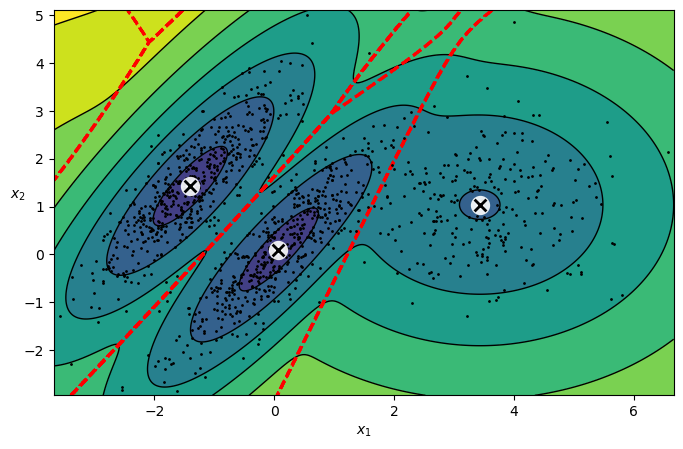

In [47]:
# extra code – this figure is almost identical to Figure 9–16
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\kelve\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known

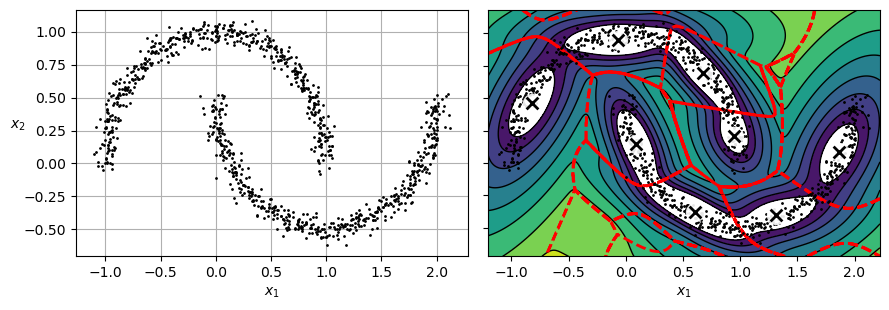

In [48]:
# extra code – this cell generates and saves Figure 9–21

X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.grid()

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

[返回](readme.md)